In [100]:
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import pandas as pd

from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as compare_psnr, mean_squared_error as compare_mse, structural_similarity

os.chdir("/data/cyc/2023-generative-remote-sensing/generative_models/guided-diffusion")



In [101]:
npz_path = 'logs/openai-2023-05-17-12-33-39-740757/samples_10000x256x256x3.npz'
data = np.load(npz_path)
images = data["arr_0"]

In [102]:
labels = data["arr_1"]

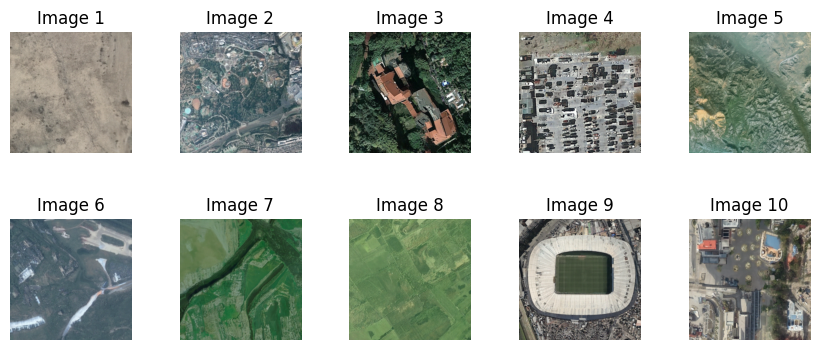

In [76]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axs.flat):
    ax.axis('off')
    ax.imshow(images[i])
    ax.set_title(f'Image {i+1}')

plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.4, wspace=0.4)

plt.show()

In [104]:
data_list = glob("datasets/decomp/AID/*/*")
target_list = list(map(lambda x: x.split("/")[-2], data_list))
unique_lst = np.unique(target_list)
mapping = {index : value for index, value in enumerate(unique_lst)}
mapping

{0: 'Airport',
 1: 'BareLand',
 2: 'BaseballField',
 3: 'Beach',
 4: 'Bridge',
 5: 'Center',
 6: 'Church',
 7: 'Commercial',
 8: 'DenseResidential',
 9: 'Desert',
 10: 'Farmland',
 11: 'Forest',
 12: 'Industrial',
 13: 'Meadow',
 14: 'MediumResidential',
 15: 'Mountain',
 16: 'Park',
 17: 'Parking',
 18: 'Playground',
 19: 'Pond',
 20: 'Port',
 21: 'RailwayStation',
 22: 'Resort',
 23: 'River',
 24: 'School',
 25: 'SparseResidential',
 26: 'Square',
 27: 'Stadium',
 28: 'StorageTanks',
 29: 'Viaduct'}

In [105]:
label_counts =  pd.Series(labels).map(mapping).value_counts().to_dict()
label_counts

{'River': 361,
 'Parking': 360,
 'SparseResidential': 355,
 'Industrial': 354,
 'Commercial': 351,
 'Airport': 350,
 'Beach': 349,
 'DenseResidential': 347,
 'Viaduct': 345,
 'Meadow': 344,
 'Playground': 343,
 'Farmland': 341,
 'Stadium': 340,
 'Square': 339,
 'RailwayStation': 333,
 'Desert': 332,
 'BareLand': 330,
 'Church': 330,
 'Pond': 330,
 'Port': 329,
 'Mountain': 327,
 'School': 325,
 'Forest': 322,
 'MediumResidential': 322,
 'BaseballField': 322,
 'Resort': 319,
 'Park': 312,
 'Bridge': 307,
 'StorageTanks': 297,
 'Center': 284}

In [106]:
save_dir = "datasets/new/AID_test0.2"
for i, img in enumerate(images):
    # 获得该图像的标签
    label = labels[i]
    # 通过mapping获得该图像的所在类别的名称
    subfolder = mapping[label]
    # 构造该图像的文件名
    filename = str(i) + '.jpg'
    # 拼接文件夹路径和文件名
    path = os.path.join(save_dir, subfolder, filename)
    # 创建类别的文件夹
    os.makedirs(os.path.dirname(path), exist_ok=True)
    # 保存图像
    Image.fromarray(img).save(path)

In [107]:
with open(os.path.join(save_dir, 'new.flist'), 'w') as f:
    for i, img in enumerate(images):
        # 获得该图像的标签
        label = labels[i]
        # 通过mapping获得该图像的所在类别的名称
        subfolder = mapping[label]
        # 构造该图像的文件名
        filename = str(i) + '.jpg'
        # 拼接文件夹路径和文件名
        path = os.path.join(save_dir, subfolder, filename)
        # 写入文件中
        f.write(path + ',' + str(label) + '\n')

In [78]:
def compare_mae(image0, image1):
    return np.mean(np.absolute(image0 - image1))

In [79]:
def compare_cosine(image0, image1):
     image0 = image0.reshape(-1)
     image1 = image1.reshape(-1)
     return np.dot(image0, image1) / (np.linalg.norm(image0) * np.linalg.norm(image1))

In [80]:
def compare_ssim(image0, image1):
    return structural_similarity(image0, image1, data_range=1., multichannel=True, channel_axis=2)

In [81]:
def find_similar_images(file_path, array, n):
    
    # 读取文件中的图片和标签
    with open(file_path, 'r') as f:
        lines = f.readlines()
    image_paths = []
    labels = []
    for line in lines:
        image_path, label = line.strip().split(',')
        if int(label) == 27:
            image_paths.append(image_path)
            labels.append(int(label))
            
    # 计算相似度
    cosine_list = []
    ssim_list = []
    mae_list = []
    array = array / 255.
    for image_path_id in range(len(image_paths)):
        image_path = image_paths[image_path_id]
        image = np.array(Image.open(image_path).resize((256, 256))) / 255.
        
        cosine_score = compare_cosine(array, image)
        ssim_score = compare_ssim(array, image)
        mae_score = compare_mae(array, image)
        
        cosine_list.append(cosine_score)
        ssim_list.append(ssim_score)
        mae_list.append(mae_score)
        
        print(f"{image_path_id}:")
        print(f"    image_path: {image_path}")
        print(f"    cosine_score: {cosine_score}")
        print(f"    ssim_score: {ssim_score}")
        print(f"    mae_score: {mae_score}")

    # 找到相似度最大的前 n 个图片的索引
    max_indexes_cosine = np.argsort(cosine_list)[::-1]
    max_indexes_ssim = np.argsort(ssim_list)[::-1]
    max_indexes_mae = np.argsort(mae_list)

    # 获取前 n 个相似图片
    image_path_cosine = []
    image_path_ssim = []
    image_path_mae = []
    for index in range(n):
        image_path_cosine.append(image_paths[max_indexes_cosine[index]])
        image_path_ssim.append(image_paths[max_indexes_ssim[index]])
        image_path_mae.append(image_paths[max_indexes_mae[index]])

    return image_path_cosine, image_path_ssim, image_path_mae

In [82]:
image_path_cosine, image_path_ssim, image_path_mae = find_similar_images("datasets/data/cls/AID_test0.2/train.flist", images[8], 5)

0:
    image_path: datasets/decomp/AID/Stadium/stadium_213.jpg
    cosine_score: 0.8697588328827512
    ssim_score: 0.134386771176609
    mae_score: 0.21434583476945468
1:
    image_path: datasets/decomp/AID/Stadium/stadium_273.jpg
    cosine_score: 0.8846727300588761
    ssim_score: 0.14670178325551994
    mae_score: 0.2091290442772161
2:
    image_path: datasets/decomp/AID/Stadium/stadium_55.jpg
    cosine_score: 0.8599305910828022
    ssim_score: 0.10467276798607804
    mae_score: 0.24784573823018793
3:
    image_path: datasets/decomp/AID/Stadium/stadium_146.jpg
    cosine_score: 0.838989298774046
    ssim_score: 0.1603794511149893
    mae_score: 0.2382556391697304
4:
    image_path: datasets/decomp/AID/Stadium/stadium_153.jpg
    cosine_score: 0.8167398354917758
    ssim_score: 0.1139724081425935
    mae_score: 0.26516566058389496
5:
    image_path: datasets/decomp/AID/Stadium/stadium_169.jpg
    cosine_score: 0.8438159461674268
    ssim_score: 0.12369649626114687
    mae_score: 0.

In [83]:
def plot_comparison(array, path):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(array)
    axs[0].axis('off')
    axs[0].set_title('Generated Image')
    axs[1].imshow(plt.imread(path))
    axs[1].axis('off')
    axs[1].set_title(f'Original Image')
    plt.show()

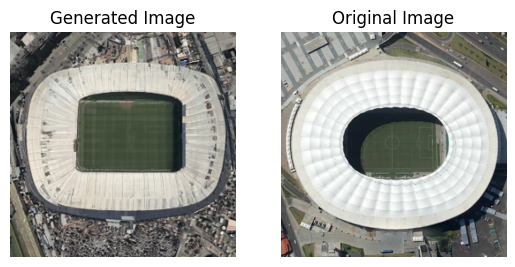

In [84]:
plot_comparison(images[8], image_path_cosine[0])

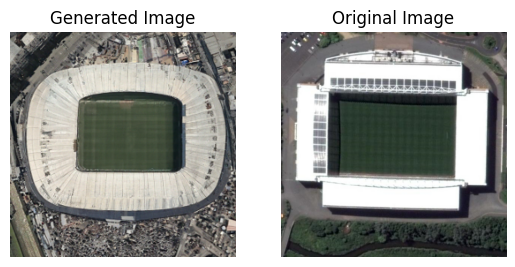

In [85]:
plot_comparison(images[8], image_path_ssim[0])


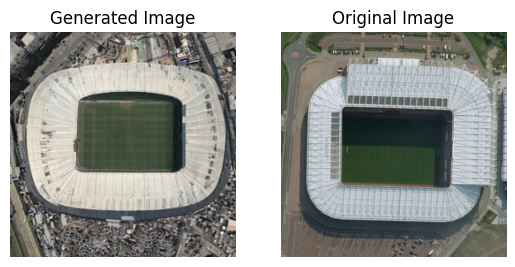

In [86]:
plot_comparison(images[8], image_path_mae[0])
